## Multiple linear regression with elastic net for power prediction using cluster-computing framework

In [1]:
import boto3
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pandas as pd
import sys
import csv
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Boto is the Amazon Web Services (AWS) SDK for Python. It is necessary to create, configure, and manage AWS services, such as EC2 and S3 using Python language.

In [2]:
S3_OBJECT = boto3.client('s3', region_name='eu-west-1', aws_access_key_id='your_key_id', aws_secret_access_key='your_secret_key')
S3_OBJECT.list_buckets()
S3_OBJECT.download_file('ccpp-dataset', 'data.csv', 'data.csv')

Since price is the 'y' axis of all the plots, it made sense to plot them side-by-side (so it's easy to compare them).
'sharey' means share 'PE' as y in each case.

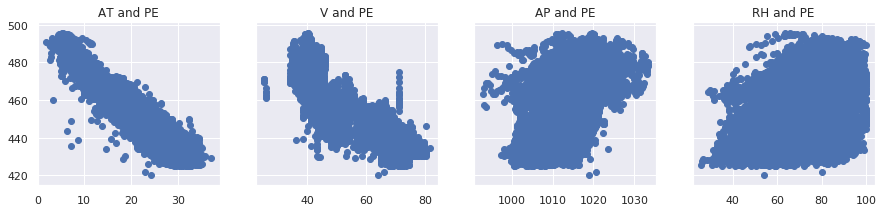

In [3]:
df = pd.read_csv('data.csv', delimiter=';')
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize =(15,3))
ax1.scatter(df['AT'], df['PE'])
ax1.set_title('AT and PE')
ax2.scatter(df['V'], df['PE'])
ax2.set_title('V and PE')
ax3.scatter(df['AP'], df['PE'])
ax3.set_title('AP and PE')
ax4.scatter(df['RH'], df['PE'])
ax4.set_title('RH and PE')
plt.show()

I drop the 'RH' column since there is no visible linear relationship between 'PE' and 'RH'.

In [4]:
df_without_RH = df.drop(columns = 'RH', axis = 1)

Now let's plot the probability density function of each of the remaining variable.

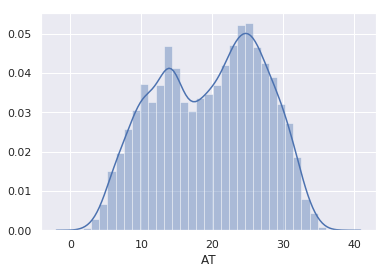

In [5]:
sns.distplot(df_without_RH['AT'])

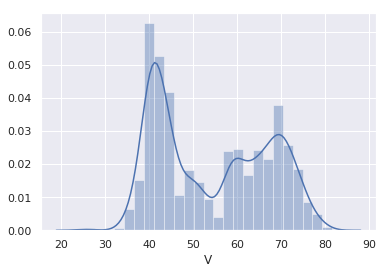

In [6]:
sns.distplot(df_without_RH['V'])

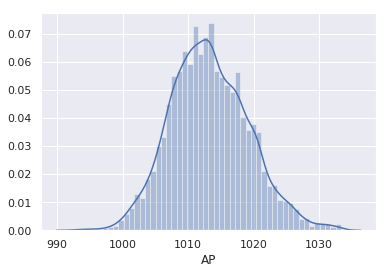

In [7]:
sns.distplot(df_without_RH['AP'])

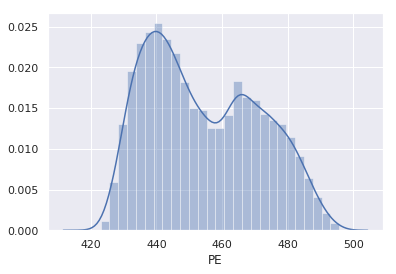

In [8]:
sns.distplot(df_without_RH['PE'])

I deal with the outliers using quantiles.

In [9]:
q = df_without_RH['AP'].quantile(0.0015)
data_2 = df_without_RH[df['AP'] > q]
q = data_2['V'].quantile(0.00075)
data_3 = data_2[data_2['V'] > q]
q = data_3['V'].quantile(0.99925)
data_4 = data_3[data_3['V'] < q]

When I remove observations, the original indexes are preserved.
If I remove observations with indexes 2 and 3, the indexes will go as: 0, 1, 4, 5, 6.
Finally, once I reset the index, a new column will be created containing the old index (just in case).
I won't be needing it, thus 'drop=True' to completely forget about it.

In [10]:
data_cleaned = data_4.reset_index(drop=True)

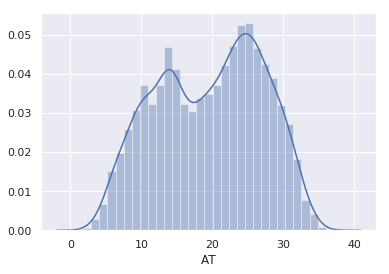

In [11]:
sns.distplot(data_cleaned['AT'])

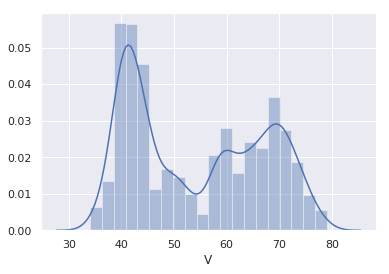

In [12]:
sns.distplot(data_cleaned['V'])

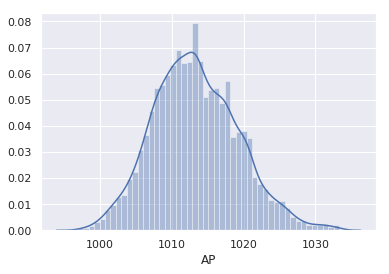

In [13]:
sns.distplot(data_cleaned['AP'])

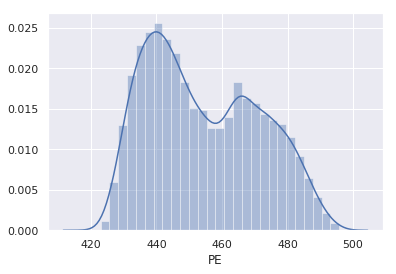

In [14]:
sns.distplot(data_cleaned['PE'])

If there are no outliers, I will use StandardScaler object to transform data into a standard scale.
Then I round all the values and save it to a new .csv file without the names of the columns, since I won't be needing them.
I also drop the index column that is natively created while saving the pandas dataframe into the .csv file.

In [15]:
scaler = StandardScaler()
scaler.fit(data_cleaned)
data_scaled = scaler.transform(data_cleaned)
df_scaled = pd.DataFrame(data = data_scaled)
df_scaled = df_scaled.round(decimals = 2)
df_scaled.to_csv('preprocessed-data.csv', sep=';', columns=None, header=False, index=False, index_label=None, decimal='.')

The code below converts .csv file into libsvm data format file.

In [16]:
def modify_line(label, line):
    modified_line = []
    modified_line.append(label)

    for num, item in enumerate(line):
        if num == 3:
            continue
        else:
            new_item = '%s:%s' % (num + 1, item)
            modified_line.append(new_item)
        
    modified_line = ' '.join(modified_line)
    modified_line += '\n'
    return modified_line
    
input_file = open('preprocessed-data.csv', 'rt')
csvreader = csv.reader(input_file, delimiter=';')
output_file = open('processed-data.data', 'wt' )

for line in csvreader:
    label = line[3]  
    modified_line = modify_line(label, line)
    output_file.write(modified_line)

The entry point into all functionality in Spark is the SparkSession class.Then I use spark.read interface to directly load dataset into Spark data frame object.


Since I want to concurrently try out different hyperparameter configurations not manually, I will use the CrossValidator object that performs this operation natively in Spark. The code below shows how to try out different elastic net parameters (i.e., maxIter, regParam, and easticNetParam) using cross validation to select the best performing model.


CrossValidator begins by splitting the dataset into a set of folds which are used as separate training and test datasets. E.g., with numFolds = 4, CrossValidator will generate 4 (training, test) dataset pairs,
For each (training, test) pair, it iterates through the set of ParamMaps:
For each ParamMaps, it fits the Estimator using those parameters, gets the fitted Model, and evaluates the Model’s performance using the Evaluator.
Then, it selects the Model produced by the best-performing set of parameters.
In my case the Evaluator is a RegressionEvaluator, and the Estimator is the LinearRegression.
After identifying the best ParamMaps, CrossValidator finally re-fits the Estimator using the best ParamMaps and the entire dataset.

Note: the maxIter parameters was chosen from 10 to 1000 due to time cost. Both regParam and elasticNetParam can vary from 0 to 1, the parameters the ParamGrid can choose from I selected empirically.

Best ParamMap set is read into a lr_best_model_param list and printed out.
Finally I pass the data prepared in the Spark format in the previous steps and three optimized hyperparameters to the LinearRegression object to train a linear regression model and calculate the root mean squared error and r-squared for further evaluation of the algorithm.

In [17]:
from __future__ import print_function
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

if __name__ == '__main__':
    spark = SparkSession\
        .builder\
        .appName('MultipleLinearRegressionWithElasticNet')\
        .master('spark://ip-172-31-11-91.eu-west-1.compute.internal:7077')\
        .getOrCreate()

    training = spark.read.format('libsvm')\
        .load('processed-data.data')

    lr = LinearRegression()
                         
    paramGrid = ParamGridBuilder()\
        .addGrid(lr.maxIter, [1000, 100, 10]) \
        .addGrid(lr.regParam, [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001]) \
        .addGrid(lr.elasticNetParam, [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05])\
        .build()


    lr_cv = CrossValidator(estimator = lr,
                      estimatorParamMaps = paramGrid,
                      evaluator = RegressionEvaluator(),
                      numFolds = 4)

    lr_model = lr_cv.fit(training)
    lr_best_model = lr_model.bestModel
    
    lr_best_model_param = [lr_best_model._java_obj.parent().getMaxIter(), 
                        lr_best_model._java_obj.parent().getRegParam(),
                        lr_best_model._java_obj.parent().getElasticNetParam()]
    
    
    print('Optimal parameters:')
    print('maxIter : %d' % lr_best_model_param[0])
    print('regParam: %f' % lr_best_model_param[1])
    print('elasticNetParam: %f' % lr_best_model_param[2])
    print('\n')
    
    
    lr = LinearRegression(maxIter = lr_best_model_param[0],
                         regParam = lr_best_model_param[1], 
                         elasticNetParam = lr_best_model_param[2], standardization = False)
    
    lrModel = lr.fit(training)
    trainingSummary = lrModel.summary
    
    print('RMSE: %f' % trainingSummary.rootMeanSquaredError)
    print('R^2 : %f' % trainingSummary.r2)
        
    spark.stop()

Optimal parameters:
maxIter : 1000
regParam: 0.001000
elasticNetParam: 0.300000


RMSE: 0.286312
R^2 : 0.918042
